# **Análisis de componentes principales**

#### Este notebook retoma el tema del análisis exploratorio a través del concepto de aprendizaje no supervisado conocido como análisis de componentes principales (PCA). Usaremos el conjunto de datos [Million Song Dataset](http://labrosa.ee.columbia.edu/millionsong/) del [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets /YearPredictionMSD) ) utilizado en Lab4a.

#### **En este notebook:**
 #### *Parte 1:* Tutorial de PCA en un conjunto de datos artificial
   #### *Vista 1:* Gaussianas bidimensionales
   #### *Parte 2:* Función PCA para aplicar en un RDD
   #### *Vista 2:* Proyección PCA
 #### *Parte 3:* Aplicación de PCA sobre la base Million Song, con aplicación de Regresión Lineal sobre la base proyectada


 
### **Parte 1: Passo a passo do PCA em um dataset artificial**

#### **Vista 1: Gaussianas bidimensionales**

#### El Análisis de Componentes Principales, o PCA, es una estrategia para la reducción de la dimensionalidad. Para entender cómo funciona PCA, usemos una base de datos generada artificialmente usando una [distribución gaussiana bidimensional] (http://en.wikipedia.org/wiki/Multivariate_normal_distribution). Esta distribución tiene como parámetros la media y la varianza de cada dimensión, así como la covarianza entre dimensiones.
 
#### Para nuestros experimentos, estableceremos la media de cada dimensión en 50 y la varianza en 1. Y probaremos dos valores de covarianza: 0 y 0,9. Cuando la covarianza es cero significa que las variables no tienen correlación y los datos son esféricos. Cuando establecemos la covarianza en 0,9, significa que las dos dimensiones tienen una correlación positiva y fuerte, es decir, cuando una variable aumenta su valor, la otra tiende a aumentar también. Cuando tenemos una fuerte correlación significa que podemos representar dos o más variables como una sola, veremos que PCA funciona muy bien para estos casos.

# **Instalacion e importacion de Recursos**

In [ ]:
!pip install pyspark==3.0.1 py4j==0.10.9

     |████████████████████████████████| 204.2 MB 27 kB/s 
     |████████████████████████████████| 198 kB 49.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=3a568d8ecf532c4546c00c1a4693aed963b34fd47fc87bf878164beca6e43e7b
  Stored in directory: /root/.cache/pip/wheels/5e/34/fa/b37b5cef503fc5148b478b2495043ba61b079120b7ff379f9b
Successfully built pyspark


#**Importacion de Librerias**

In [ ]:
import math
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
sc =SparkContext.getOrCreate()
import os

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

def create2DGaussian(mn, sigma, cov, n):
    """Randomly sample points from a two-dimensional Gaussian distribution"""
    np.random.seed(142)
    return np.random.multivariate_normal(np.array([mn, mn]), np.array([[sigma, cov], [cov, sigma]]), n)

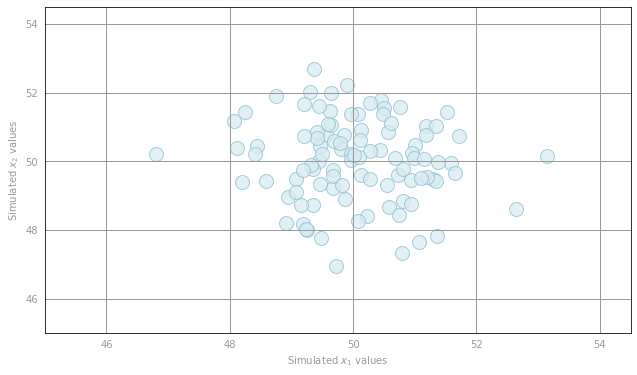

In [ ]:
dataRandom = create2DGaussian(mn=50, sigma=1, cov=0, n=100)

# generate layout and plot data
fig, ax = preparePlot(np.arange(46, 55, 2), np.arange(46, 55, 2))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45, 54.5), ax.set_ylim(45, 54.5)
plt.scatter(dataRandom[:,0], dataRandom[:,1], s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
pass

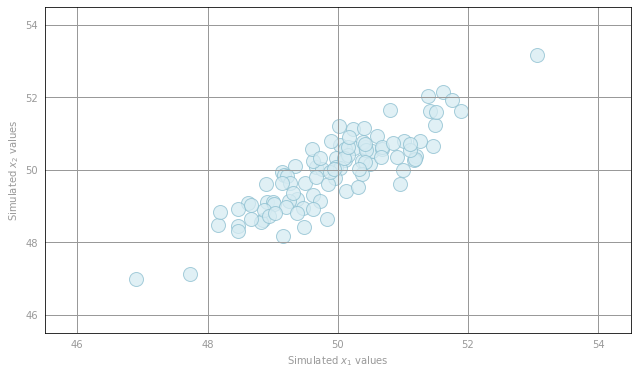

In [ ]:
dataCorrelated = create2DGaussian(mn=50, sigma=1, cov=.9, n=100)

# generate layout and plot data
fig, ax = preparePlot(np.arange(46, 55, 2), np.arange(46, 55, 2))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45.5, 54.5), ax.set_ylim(45.5, 54.5)
plt.scatter(dataCorrelated[:,0], dataCorrelated[:,1], s=14**2, c='#d6ebf2',
            edgecolors='#8cbfd0', alpha=0.75)
pass

#### **(1a) Interpretación del PCA**

#### PCA puede interpretarse como la identificación de las direcciones en las que los datos varían más. En el primer paso de PCA, necesitamos centralizar nuestros datos. El primer paso requiere que calculemos el promedio de cada atributo (columna) en la base de datos. Luego, para cada observación (fila), modifique los valores de los atributos por la media correspondiente. De esta forma tendremos una base de datos en la que cada atributo tiene una media de cero.

#### Tenga en cuenta que `correlatedData` es un RDD de arreglos NumPy. Esto nos permite hacer algunas operaciones más fácilmente. Por ejemplo, si usamos la transformación `sum()`, PySpark hará la suma de los valores de cada columna.

In [ ]:
# EXERCICIO
correlatedData = sc.parallelize(dataCorrelated)

meanCorrelated = correlatedData.mean()
correlatedDataZeroMean = correlatedData.map(lambda a: a - meanCorrelated)

print (meanCorrelated)
print (correlatedData.take(1))
print (correlatedDataZeroMean.take(1))

[49.95739037 49.97180477]
[array([49.6717712 , 50.07531969])]
[array([-0.28561917,  0.10351492])]


In [ ]:
# TEST Interpreting PCA (1a)
from test_helper import Test
Test.assertTrue(np.allclose(meanCorrelated, [49.95739037, 49.97180477]),
                'incorrect value for meanCorrelated')
Test.assertTrue(np.allclose(correlatedDataZeroMean.take(1)[0], [-0.28561917, 0.10351492]),
                'incorrect value for correlatedDataZeroMean')

1 test passed.
1 test passed.


#### **(1b) Matriz de covarianza**

#### Calculemos la matriz de covarianza de nuestros datos. Si definimos $\scriptsize \mathbf{X} \in \mathbb{R}^{n \times d}$ como la matriz de datos centrada en cero, entonces la matriz de covarianza se define como: $$ \mathbf{C } _{\mathbf X} = \frac{1}{n} \mathbf{X}^\top \mathbf{X} \,.$$ Esta matriz se puede calcular calculando el producto vectorial de cada fila consigo misma, en luego realizar la suma de las matrices resultantes y, finalmente, dividir por el número total de objetos en la base de datos. Los datos son bidimensionales, por lo que la matriz de covarianza es una matriz de 2x2.
 
#### Tenga en cuenta que [np.outer()](http://docs.scipy.org/doc/numpy/reference/generated/numpy.outer.html) se puede usar para calcular el producto externo de dos arreglos NumPy .

In [ ]:
# EXERCICIO
# Compute the covariance matrix using outer products and correlatedDataZeroMean
correlatedCov = correlatedDataZeroMean.map(lambda x: np.outer(x,x)).sum()/correlatedDataZeroMean.count()
print (correlatedCov)

[[ 0.99558386  0.90148989]
 [ 0.90148989  1.08607497]]


In [ ]:
# TEST Sample covariance matrix (1b)
covResult = [[ 0.99558386,  0.90148989], [0.90148989, 1.08607497]]
Test.assertTrue(np.allclose(covResult, correlatedCov), 'incorrect value for correlatedCov')

1 test passed.


#### **(1c) Función de covarianza**

#### Utilizando las expresiones del ejercicio anterior, escribe una función que calcule la matriz de covarianza de un RDD arbitrario. Tenga en cuenta que los datos deben estar centrados para que tengan una media cero.

In [ ]:
# EXERCICIO
def estimateCovariance(data):
    """Compute the covariance matrix for a given rdd.

    Note:
        The multi-dimensional covariance array should be calculated using outer products.  Don't
        forget to normalize the data by first subtracting the mean.

    Args:
        data (RDD of np.ndarray):  An `RDD` consisting of NumPy arrays.

    Returns:
        np.ndarray: A multi-dimensional array where the number of rows and columns both equal the
            length of the arrays in the input `RDD`.
    """
    meanCorrelated = data.mean()
    correlatedDataZeroMean = data.map(lambda a: a - meanCorrelated)

    
    return correlatedDataZeroMean.map(lambda x: np.outer(x,x)).sum()/data.count()

correlatedCovAuto= estimateCovariance(correlatedData)
print (correlatedCovAuto)

[[ 0.99558386  0.90148989]
 [ 0.90148989  1.08607497]]


In [ ]:
# TEST Covariance function (1c)
correctCov = [[ 0.99558386,  0.90148989], [0.90148989, 1.08607497]]
Test.assertTrue(np.allclose(correctCov, correlatedCovAuto),
                'incorrect value for correlatedCovAuto')

1 test passed.


#### **(1d) Valores propios y vectores propios**

#### Ahora que tenemos la matriz de covarianza, podemos usarla para encontrar las direcciones de mayor variación en los datos. Los valores propios y los vectores propios nos traen dicha información. Los $\scriptsize d$ vectores propios de la matriz de covarianza nos dan las direcciones de mayor varianza y se denominan componentes principales. Los valores propios asociados son las varianzas en estas direcciones. En particular, el atuovector correspondiente al valor propio más grande es la dirección de máxima varianza. El cálculo de los autovalores y autovectores de la matriz de covarianza tiene una complejidad de aproximadamente $O(d^3)$ para una matriz d x d. Cuando nuestro $d$ es lo suficientemente pequeño, podemos calcular los valores propios y los vectores propios localmente.
 
#### Use la función [eigh](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html) de la biblioteca `numpy.linalg` para calcular los valores propios ​y vectores propios. Luego ordene los vectores propios según los valores propios, de mayor a menor, generando una matriz donde los vectores propios son las columnas (y la primera columna es el vector propio más grande).

#### Tenga en cuenta que la función [np.argsort](http://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html#numpy-argsort) puede usarse para obtener el orden de índices de elementos en orden ascendente o descendente. Finalmente, coloque el vector propio más grande en la variable `topComponent`.

In [ ]:
# EXERCICIO
from numpy.linalg import eigh

# Calculate the eigenvalues and eigenvectors from correlatedCovAuto
eigVals, eigVecs = eigh(correlatedCovAuto)
print 'eigenvalues: {0}'.format(eigVals)
print '\neigenvectors: \n{0}'.format(eigVecs)

# Use np.argsort to find the top eigenvector based on the largest eigenvalue
inds = np.argsort(eigVals)
topComponent = eigVecs[:,inds[-1]]
print '\ntop principal component: {0}'.format(topComponent)

eigenvalues: [ 0.13820481  1.94345403]

eigenvectors: 
[[-0.72461254  0.68915649]
 [ 0.68915649  0.72461254]]

top principal component: [ 0.68915649  0.72461254]


In [ ]:
# TEST Eigendecomposition (1d)
def checkBasis(vectors, correct):
    return np.allclose(vectors, correct) or np.allclose(np.negative(vectors), correct)
Test.assertTrue(checkBasis(topComponent, [0.68915649, 0.72461254]),
                'incorrect value for topComponent')

1 test passed.


#### **(1e) puntajes PCA**

#### Calculamos los componentes principales para una base de datos no esférica. Ahora usemos este componente principal para derivar una representación unidimensional de los datos originales. Para calcular la representación compacta, que se llama puntajes PCA, calcule el producto interno entre cada objeto en la base original y el componente principal.

In [ ]:
# EXERCICIO
# Use the topComponent and the data from correlatedData to generate PCA scores
correlatedDataScores = correlatedData.map(lambda x:x.dot(topComponent))
print 'one-dimensional data (first three):\n{0}'.format(np.asarray(correlatedDataScores.take(3)))

one-dimensional data (first three):
[ 70.51682806  69.30622356  71.13588168]


In [ ]:
# TEST PCA Scores (1e)
firstThree = [70.51682806, 69.30622356, 71.13588168]
Test.assertTrue(checkBasis(correlatedDataScores.take(3), firstThree),
                'incorrect value for correlatedDataScores')

1 test passed.


### **Parte 2: Función PCA para aplicar a un RDD**

#### **(2a) Función PCA**

#### Ahora tenemos todos los ingredientes para calcular una función PCA. Nuestra función debe ser genérica para calcular los componentes principales de $k$ y las puntuaciones de PCA. Escriba la función `pca` genérica y pruebe usando `correlatedData` y $\scriptsize k = 2$. Sugerencia: Utilice los resultados de la Parte (1c), la Parte (1d) y la Parte (1e).
 
#### Nota: Como se discutió anteriormente, esta implementación es eficiente mientras $\scriptsize d$ es pequeño, pero existen algoritmos distribuidos más eficientes para $\scriptsize d$ grandes.

In [ ]:
# EXERCICIO
def pca(data, k=2):
    """Computes the top `k` principal components, corresponding scores, and all eigenvalues.

    Note:
        All eigenvalues should be returned in sorted order (largest to smallest). `eigh` returns
        each eigenvectors as a column.  This function should also return eigenvectors as columns.

    Args:
        data (RDD of np.ndarray): An `RDD` consisting of NumPy arrays.
        k (int): The number of principal components to return.

    Returns:
        tuple of (np.ndarray, RDD of np.ndarray, np.ndarray): A tuple of (eigenvectors, `RDD` of
            scores, eigenvalues).  Eigenvectors is a multi-dimensional array where the number of
            rows equals the length of the arrays in the input `RDD` and the number of columns equals
            `k`.  The `RDD` of scores has the same number of rows as `data` and consists of arrays
            of length `k`.  Eigenvalues is an array of length d (the number of features).
    """
    covariance = estimateCovariance(data)
    eigVals, eigVecs = eigh(covariance)
    
    # Return the `k` principal components, `k` scores, and all eigenvalues
    inds = np.argsort(eigVals)
    topKCols = inds[::-1][:k]
    correlatedDataScores = data.map(lambda x: x.dot(eigVecs[:,topKCols]))
    
    return (eigVecs[:,topKCols],correlatedDataScores,eigVals[inds[::-1]])

# Run pca on correlatedData with k = 2
topComponentsCorrelated, correlatedDataScoresAuto, eigenvaluesCorrelated = pca(correlatedData)

# Note that the 1st principal component is in the first column
print 'topComponentsCorrelated: \n{0}'.format(topComponentsCorrelated)
print ('\ncorrelatedDataScoresAuto (first three): \n{0}'
       .format('\n'.join(map(str, correlatedDataScoresAuto.take(3)))))
print '\neigenvaluesCorrelated: \n{0}'.format(eigenvaluesCorrelated)

# Create a higher dimensional test set
pcaTestData = sc.parallelize([np.arange(x, x + 4) for x in np.arange(0, 20, 4)])
componentsTest, testScores, eigenvaluesTest = pca(pcaTestData, 3)

print '\npcaTestData: \n{0}'.format(np.array(pcaTestData.collect()))
print '\ncomponentsTest: \n{0}'.format(componentsTest)
print ('\ntestScores (first three): \n{0}'
       .format('\n'.join(map(str, testScores.take(3)))))
print '\neigenvaluesTest: \n{0}'.format(eigenvaluesTest)

topComponentsCorrelated: 
[[ 0.68915649 -0.72461254]
 [ 0.72461254  0.68915649]]

correlatedDataScoresAuto (first three): 
[ 70.51682806  -1.48305648]
[ 69.30622356  -1.5888655 ]
[ 71.13588168  -1.86710679]

eigenvaluesCorrelated: 
[ 1.94345403  0.13820481]

pcaTestData: 
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]]

componentsTest: 
[[  5.00000000e-01   3.37478000e-17  -1.96655087e-01]
 [  5.00000000e-01   2.51432321e-16  -7.29615248e-01]
 [  5.00000000e-01  -7.07106781e-01   4.63135168e-01]
 [  5.00000000e-01   7.07106781e-01   4.63135168e-01]]

testScores (first three): 
[ 3.          0.70710678  1.58606059]
[ 11.           0.70710678   1.58606059]
[ 19.           0.70710678   1.58606059]

eigenvaluesTest: 
[  1.28000000e+02   7.02551827e-31  -6.87382692e-15  -2.95932189e-14]


In [ ]:
# TEST PCA Function (2a)
Test.assertTrue(checkBasis(topComponentsCorrelated.T,
                           [[0.68915649,  0.72461254], [-0.72461254, 0.68915649]]),
                'incorrect value for topComponentsCorrelated')
firstThreeCorrelated = [[70.51682806, 69.30622356, 71.13588168], [1.48305648, 1.5888655, 1.86710679]]
Test.assertTrue(np.allclose(firstThreeCorrelated,
                            np.vstack(np.abs(correlatedDataScoresAuto.take(3))).T),
                'incorrect value for firstThreeCorrelated')
Test.assertTrue(np.allclose(eigenvaluesCorrelated, [1.94345403, 0.13820481]),
                           'incorrect values for eigenvaluesCorrelated')
topComponentsCorrelatedK1, correlatedDataScoresK1, eigenvaluesCorrelatedK1 = pca(correlatedData, 1)
Test.assertTrue(checkBasis(topComponentsCorrelatedK1.T, [0.68915649,  0.72461254]),
               'incorrect value for components when k=1')
Test.assertTrue(np.allclose([70.51682806, 69.30622356, 71.13588168],
                            np.vstack(np.abs(correlatedDataScoresK1.take(3))).T),
                'incorrect value for scores when k=1')
Test.assertTrue(np.allclose(eigenvaluesCorrelatedK1, [1.94345403, 0.13820481]),
                           'incorrect values for eigenvalues when k=1')
Test.assertTrue(checkBasis(componentsTest.T[0], [ .5, .5, .5, .5]),
                'incorrect value for componentsTest')
Test.assertTrue(np.allclose(np.abs(testScores.first()[0]), 3.),
                'incorrect value for testScores')
Test.assertTrue(np.allclose(eigenvaluesTest, [ 128, 0, 0, 0 ]), 'incorrect value for eigenvaluesTest')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### **(2b) PCA en `dataRandom`**

#### Ahora usa la función PCA para encontrar los dos componentes principales de la base esférica `dataRandom`.

In [ ]:
# EXERCICIO
randomData = sc.parallelize(dataRandom)

# Use pca on randomData
topComponentsRandom, randomDataScoresAuto, eigenvaluesRandom = pca(randomData,k=2)

print 'topComponentsRandom: \n{0}'.format(topComponentsRandom)
print ('\nrandomDataScoresAuto (first three): \n{0}'
       .format('\n'.join(map(str, randomDataScoresAuto.take(3)))))
print '\neigenvaluesRandom: \n{0}'.format(eigenvaluesRandom)

topComponentsRandom: 
[[-0.2522559  -0.96766056]
 [ 0.96766056 -0.2522559 ]]

randomDataScoresAuto (first three): 
[ 36.61068572 -61.3489929 ]
[ 35.97314295 -62.08813671]
[ 35.59836628 -60.61390415]

eigenvaluesRandom: 
[ 1.4204546   0.99521397]


In [ ]:
# TEST PCA on `dataRandom` (2b)
Test.assertTrue(checkBasis(topComponentsRandom.T,
                           [[-0.2522559 ,  0.96766056], [-0.96766056,  -0.2522559]]),
                'incorrect value for topComponentsRandom')
firstThreeRandom = [[36.61068572,  35.97314295,  35.59836628],
                    [61.3489929 ,  62.08813671,  60.61390415]]
Test.assertTrue(np.allclose(firstThreeRandom, np.vstack(np.abs(randomDataScoresAuto.take(3))).T),
                'incorrect value for randomDataScoresAuto')
Test.assertTrue(np.allclose(eigenvaluesRandom, [1.4204546, 0.99521397]),
                            'incorrect value for eigenvaluesRandom')

1 test passed.
1 test passed.
1 test passed.


#### **Vista 2: Proyección PCA**

#### Veamos el gráfico de los datos originales y la reconstrucción unidimensional usando el componente principal para ver cómo se ve la solución PCA. Los datos de PCA se trazan en verde y las líneas representan los dos vectores de componentes principales.

In [ ]:
def projectPointsAndGetLines(data, components, xRange):
    """Project original data onto first component and get line details for top two components."""
    topComponent= components[:, 0]
    slope1, slope2 = components[1, :2] / components[0, :2]

    means = data.mean()[:2]
    demeaned = data.map(lambda v: v - means)
    projected = demeaned.map(lambda v: (v.dot(topComponent) /
                                        topComponent.dot(topComponent)) * topComponent)
    remeaned = projected.map(lambda v: v + means)
    x1,x2 = zip(*remeaned.collect())

    lineStartP1X1, lineStartP1X2 = means - np.asarray([xRange, xRange * slope1])
    lineEndP1X1, lineEndP1X2 = means + np.asarray([xRange, xRange * slope1])
    lineStartP2X1, lineStartP2X2 = means - np.asarray([xRange, xRange * slope2])
    lineEndP2X1, lineEndP2X2 = means + np.asarray([xRange, xRange * slope2])

    return ((x1, x2), ([lineStartP1X1, lineEndP1X1], [lineStartP1X2, lineEndP1X2]),
            ([lineStartP2X1, lineEndP2X1], [lineStartP2X2, lineEndP2X2]))

In [ ]:
((x1, x2), (line1X1, line1X2), (line2X1, line2X2)) = \
    projectPointsAndGetLines(correlatedData, topComponentsCorrelated, 5)

# generate layout and plot data
fig, ax = preparePlot(np.arange(46, 55, 2), np.arange(46, 55, 2), figsize=(7, 7))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45.5, 54.5), ax.set_ylim(45.5, 54.5)
plt.plot(line1X1, line1X2, linewidth=3.0, c='#8cbfd0', linestyle='--')
plt.plot(line2X1, line2X2, linewidth=3.0, c='#d6ebf2', linestyle='--')
plt.scatter(dataCorrelated[:,0], dataCorrelated[:,1], s=14**2, c='#d6ebf2',
            edgecolors='#8cbfd0', alpha=0.75)
plt.scatter(x1, x2, s=14**2, c='#62c162', alpha=.75)
pass

In [ ]:
((x1, x2), (line1X1, line1X2), (line2X1, line2X2)) = \
    projectPointsAndGetLines(randomData, topComponentsRandom, 5)

# generate layout and plot data
fig, ax = preparePlot(np.arange(46, 55, 2), np.arange(46, 55, 2), figsize=(7, 7))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45.5, 54.5), ax.set_ylim(45.5, 54.5)
plt.plot(line1X1, line1X2, linewidth=3.0, c='#8cbfd0', linestyle='--')
plt.plot(line2X1, line2X2, linewidth=3.0, c='#d6ebf2', linestyle='--')
plt.scatter(dataRandom[:,0], dataRandom[:,1], s=14**2, c='#d6ebf2',
            edgecolors='#8cbfd0', alpha=0.75)
plt.scatter(x1, x2, s=14**2, c='#62c162', alpha=.75)
pass

#### **(2c) Explicación de la variación**

#### Finalmente, cuantifiquemos qué parte de la varianza capturó el PCA en cada uno de los datos analizados. Para ello, calcularemos la relación entre la suma de los valores propios $k$ utilizados y la suma de todos los valores propios.

In [ ]:
# EXERCICIO
def varianceExplained(data, k=1):
    """Calculate the fraction of variance explained by the top `k` eigenvectors.

    Args:
        data (RDD of np.ndarray): An RDD that contains NumPy arrays which store the
            features for an observation.
        k: The number of principal components to consider.

    Returns:
        float: A number between 0 and 1 representing the percentage of variance explained
            by the top `k` eigenvectors.
    """
    components, scores, eigenvalues = pca(data,k)
    return sum(eigenvalues[:k])/sum(eigenvalues)

varianceRandom1 = varianceExplained(randomData, 1)
varianceCorrelated1 = varianceExplained(correlatedData, 1)
varianceRandom2 = varianceExplained(randomData, 2)
varianceCorrelated2 = varianceExplained(correlatedData, 2)
varianceThreeD2 = varianceExplained(threeDData, 2)
print ('Percentage of variance explained by the first component of randomData: {0:.1f}%'
       .format(varianceRandom1 * 100))
print ('Percentage of variance explained by both components of randomData: {0:.1f}%'
       .format(varianceRandom2 * 100))
print ('\nPercentage of variance explained by the first component of correlatedData: {0:.1f}%'.
       format(varianceCorrelated1 * 100))
print ('Percentage of variance explained by both components of correlatedData: {0:.1f}%'
       .format(varianceCorrelated2 * 100))
print ('\nPercentage of variance explained by the first two components of threeDData: {0:.1f}%'
       .format(varianceThreeD2 * 100))

Percentage of variance explained by the first component of randomData: 58.8%
Percentage of variance explained by both components of randomData: 100.0%

Percentage of variance explained by the first component of correlatedData: 93.4%
Percentage of variance explained by both components of correlatedData: 100.0%

Percentage of variance explained by the first two components of threeDData: 100.0%


In [ ]:
# TEST Variance explained (2d)
Test.assertTrue(np.allclose(varianceRandom1, 0.588017172066), 'incorrect value for varianceRandom1')
Test.assertTrue(np.allclose(varianceCorrelated1, 0.933608329586),
                'incorrect value for varianceCorrelated1')
Test.assertTrue(np.allclose(varianceRandom2, 1.0), 'incorrect value for varianceRandom2')
Test.assertTrue(np.allclose(varianceCorrelated2, 1.0), 'incorrect value for varianceCorrelated2')
Test.assertTrue(np.allclose(varianceThreeD2, 0.993967356912), 'incorrect value for varianceThreeD2')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test failed. incorrect value for varianceThreeD2


 
### **Parte 3: Aplicación de PCA en la base Million Song, con aplicación de Regresión Lineal en la base proyectada**

#### **(3a) Cargando datos desde el conjunto de datos**

#### Repitamos los procedimientos realizados en Lab4a para cargar y analizar la base de datos. También vamos a reescribir algunas de las funciones de utilidad de ese laboratorio.

In [ ]:
import os
baseDir = os.path.join('Data')
inputPath = os.path.join('Aula04', 'millionsong.txt')
fileName = os.path.join(baseDir, inputPath)

numPartitions = 2
rawData = sc.textFile(fileName, numPartitions)

print(rawData.first())

2001.0,0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817


In [ ]:
from pyspark.mllib.regression import LabeledPoint
import sys

def parsePoint(line):
    """Converts a comma separated unicode string into a `LabeledPoint`.

    Args:
        line (unicode): Comma separated unicode string where the first element is the label and the
            remaining elements are features.

    Returns:
        LabeledPoint: The line is converted into a `LabeledPoint`, which consists of a label and
            features.
    """
    Point = map(float,line.split(','))
    return LabeledPoint(Point[0]-1922,Point[1:])

baselineRL = 17.017
baselineInteract = 15.690

millionRDD = rawData.map(parsePoint)
print(millionRDD.take(1))

In [ ]:
def squaredError(label, prediction):
    """Calculates the the squared error for a single prediction.

    Args:
        label (float): The correct value for this observation.
        prediction (float): The predicted value for this observation.

    Returns:
        float: The difference between the `label` and `prediction` squared.
    """
    return np.square(label-prediction)

def calcRMSE(labelsAndPreds):
    """Calculates the root mean squared error for an `RDD` of (label, prediction) tuples.

    Args:
        labelsAndPred (RDD of (float, float)): An `RDD` consisting of (label, prediction) tuples.

    Returns:
        float: The square root of the mean of the squared errors.
    """
    return np.sqrt(labelsAndPreds.map(lambda rec: squaredError(rec[0],rec[1])).mean())

#### **(3b) PCA de LabeledPoint**

#### Reescribamos la función `pca`, ahora llamada `pcaLP`, para recibir un RDD de LabeledPoints. Deberá realizar dos cambios: el RDD que se pasará a `estimateCovariance` debe ser una transformación de `datos` para contener solo las `características` del LabeledPoint. La función return debe transformar solo las `características` usando los vectores propios.

In [ ]:
def pcaLP(data, k=2):
    """Computes the top `k` principal components, corresponding scores, and all eigenvalues.

    Note:
        All eigenvalues should be returned in sorted order (largest to smallest). `eigh` returns
        each eigenvectors as a column.  This function should also return eigenvectors as columns.

    Args:
        data (RDD of np.ndarray): An `RDD` consisting of NumPy arrays.
        k (int): The number of principal components to return.

    Returns:
        tuple of (np.ndarray, RDD of np.ndarray, np.ndarray): A tuple of (eigenvectors, `RDD` of
            scores, eigenvalues).  Eigenvectors is a multi-dimensional array where the number of
            rows equals the length of the arrays in the input `RDD` and the number of columns equals
            `k`.  The `RDD` of scores has the same number of rows as `data` and consists of arrays
            of length `k`.  Eigenvalues is an array of length d (the number of features).
    """
    cov = estimateCovariance(data.map(lambda x: x.features))
    eigVals, eigVecs = eigh(cov)
    inds = np.argsort(-eigVals)
    vecs = eigVecs[:,inds[:k]]
    vals = eigVals[inds[:cov.shape[0]]]

    # Return the `k` principal components, `k` scores, and all eigenvalues
    return data.map(lambda x: LabeledPoint(x.label,x.features.dot(vecs)))

#### **(3c) Determinación del valor de k**

#### Usemos la función `varianceExplained` aplicada a `millionRDD` (pista: primero debe realizar una transformación) para determinar el valor de k que usaremos para las pruebas de regresión lineal.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
def varianceExplained(data, k=1):
    """Calculate the fraction of variance explained by the top `k` eigenvectors.

    Args:
        data (RDD of np.ndarray): An RDD that contains NumPy arrays which store the
            features for an observation.
        k: The number of principal components to consider.

    Returns:
        float: A number between 0 and 1 representing the percentage of variance explained
            by the top `k` eigenvectors.
    """
    components, scores, eigenvalues = pca(data,k)
    return sum(eigenvalues[:k])/sum(eigenvalues)

varianceRandom1 = varianceExplained(randomData, 1)
varianceCorrelated1 = varianceExplained(correlatedData, 1)
varianceRandom2 = varianceExplained(randomData, 2)
varianceCorrelated2 = varianceExplained(correlatedData, 2)
varianceThreeD2 = varianceExplained(threeDData, 2)
print ('Percentage of variance explained by the first component of randomData: {0:.1f}%'
       .format(varianceRandom1 * 100))
print ('Percentage of variance explained by both components of randomData: {0:.1f}%'
       .format(varianceRandom2 * 100))
print ('\nPercentage of variance explained by the first component of correlatedData: {0:.1f}%'.
       format(varianceCorrelated1 * 100))
print ('Percentage of variance explained by both components of correlatedData: {0:.1f}%'
       .format(varianceCorrelated2 * 100))
print ('\nPercentage of variance explained by the first two components of threeDData: {0:.1f}%'
       .format(varianceThreeD2 * 100))

In [ ]:
for k in range(1,10):
    varexp = varianceExplained(millionRDD.map(lambda x: x.features), k)
    print('Variation explained by {} components is {}'.format(k,varexp))

#### **(3d) Regresión lineal**

#### Apliquemos la regresión lineal del laboratorio 4a al RDD del PCA de millones de datos de canciones para k = 2, k=6 y k=8. Los resultados se compararán entre sí y con los resultados obtenidos en el Laboratorio 4a.

In [ ]:
from pyspark.mllib.regression import LinearRegressionWithSGD
# Values to use when training the linear regression model
numIters = 2000  # iterations
alpha = 1.0  # step
miniBatchFrac = 1.0  # miniBatchFraction
reg = 1e-1  # regParam
regType = None#'l2'  # regType
useIntercept = True  # intercept

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
# Run pca using scaledData
pcaMillionRDD = pcaLP(millionRDD, 2)

weights = [.8, .1, .1]
seed = 42
parsedTrainData, parsedValData, parsedTestData = pcaMillionRDD.randomSplit(weights, seed)

pcaModel = LinearRegressionWithSGD.train(parsedTrainData, iterations = numIters, step = alpha, miniBatchFraction = 1.0,
                                          regParam=reg,regType=regType, intercept=useIntercept)
labelsAndPreds = parsedValData.map(lambda lp: (lp.label, pcaModel.predict(lp.features)))
rmseValLPCA2 = calcRMSE(labelsAndPreds)

In [ ]:
pcaMillionRDD = pcaLP(millionRDD, 6)

weights = [.8, .1, .1]
seed = 42
parsedTrainData, parsedValData, parsedTestData = pcaMillionRDD.randomSplit(weights, seed)

pcaModel = LinearRegressionWithSGD.train(parsedTrainData, iterations = numIters, step = alpha, miniBatchFraction = 1.0,
                                          regParam=reg,regType=regType, intercept=useIntercept)
labelsAndPreds = parsedValData.map(lambda lp: (lp.label, pcaModel.predict(lp.features)))
rmseValLPCA6 = calcRMSE(labelsAndPreds)

In [ ]:
pcaMillionRDD = pcaLP(millionRDD, 8)

weights = [.8, .1, .1]
seed = 42
parsedTrainData, parsedValData, parsedTestData = pcaMillionRDD.randomSplit(weights, seed)

pcaModel = LinearRegressionWithSGD.train(parsedTrainData, iterations = numIters, step = alpha, miniBatchFraction = 1.0,
                                          regParam=reg,regType=regType, intercept=useIntercept)
labelsAndPreds = parsedValData.map(lambda lp: (lp.label, pcaModel.predict(lp.features)))
rmseValLPCA8 = calcRMSE(labelsAndPreds)

In [ ]:
print ('Validation RMSE:\n\tLinear Regression (orig.) = {0:.3f}\n\tLinear Regression Interact = {1:.3f}' +
       '\n\tLR PCA (k=2) = {2:.3f}\n\tLR PCA (k=6) = {3:.3f}\n\tLR PCA (k=8) = {4:.3f}' 
      ).format(baselineRL, baselineInteract, rmseValLPCA2, rmseValLPCA6, rmseValLPCA8)